In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier as rnd_frst
from sklearn.model_selection import cross_val_score, GridSearchCV, \
                                    LeaveOneOut, RepeatedKFold, train_test_split
from sklearn.metrics import make_scorer, roc_curve, auc, log_loss, \
                            f1_score, brier_score_loss, precision_score, recall_score, \
                            confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import xgboost as xgb

from itertools import combinations
import random
import time

# Input data files are available in the read-only "../input/" directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/march-machine-learning-mania-2025/Conferences.csv
/kaggle/input/march-machine-learning-mania-2025/SeedBenchmarkStage1.csv
/kaggle/input/march-machine-learning-mania-2025/WNCAATourneyDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2025/WRegularSeasonCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/MNCAATourneySeedRoundSlots.csv
/kaggle/input/march-machine-learning-mania-2025/MRegularSeasonDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2025/MNCAATourneyCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/MGameCities.csv
/kaggle/input/march-machine-learning-mania-2025/WSecondaryTourneyCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/WGameCities.csv
/kaggle/input/march-machine-learning-mania-2025/MSeasons.csv
/kaggle/input/march-machine-learning-mania-2025/WNCAATourneySlots.csv
/kaggle/input/march-machine-learning-mania-2025/MSecondaryTourneyTeams.csv
/kaggle/input/march-machine-learning-mania-20

In [2]:
# Team names, IDs; conferences
MTeams = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MTeams.csv')
WTeams = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/WTeams.csv')

MTeamConfs = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MTeamConferences.csv')
WTeamConfs = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/WTeamConferences.csv')


# Dates and MM regions
# Day 132 is Selection Sunday and Day 154 is men's championship game
MSeasons = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MSeasons.csv')
WSeasons = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/WSeasons.csv')

# Seeds for MM, regions are W-Z and double seeds have a's or b's'
MSeeds = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MNCAATourneySeeds.csv')
WSeeds = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/WNCAATourneySeeds.csv')

# Regular season results (day 132 or earlier), WLoc is location of winning team
# Box scores are in the detail files
MRegSzn = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MRegularSeasonCompactResults.csv')
MRegSznDetail = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MRegularSeasonDetailedResults.csv')
MConfTourney = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MConferenceTourneyGames.csv')

WRegSzn = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/WRegularSeasonCompactResults.csv')
WRegSznDetail = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/WRegularSeasonDetailedResults.csv')
WConfTourney = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/WConferenceTourneyGames.csv')

# Tournament results (after day 132)
MTourney = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MNCAATourneyCompactResults.csv')
MTourneyDetail = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MNCAATourneyDetailedResults.csv')
MSlots = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MNCAATourneySlots.csv')

WTourney = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/WNCAATourneyCompactResults.csv')
WTourneyDetail = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/WNCAATourneyDetailedResults.csv')
WSlots = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/WNCAATourneySlots.csv')


# Rankings (not all systems necessarily available this year)
MRanks = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/MMasseyOrdinals.csv')
SeedBenchmarks = pd.read_csv('/kaggle/input/march-machine-learning-mania-2025/SeedBenchmarkStage1.csv')


In [3]:
# Here I'm adding a self-created sheet that has aggregate pre-tournament championship odds
MOdds = pd.read_csv('/kaggle/input/mens-madness-odds/MOdds_s16.csv')
WOdds = pd.read_csv('/kaggle/input/mens-madness-odds/WOdds.csv')

In [4]:
# Get the Massey composite ranks on the last day of each season

final_ranks = MRanks[(MRanks['RankingDayNum'] == 133)]
final_ranks_25 = MRanks[(MRanks['RankingDayNum'] == 128) & (MRanks['Season'] == 2025)]

final_ranks = pd.concat([final_ranks, final_ranks_25])

team_ranks = final_ranks.groupby(['Season', 'TeamID'])['OrdinalRank'].mean().reset_index()

In [5]:
# The original seeds table needs to be modified to convert seed #s to integers
# and remove the 'a's or 'b's for the teams playing in the First Four

def get_seeds(Seeds, Teams, Tourney):
    t_teams = pd.merge(Seeds, Teams[['TeamID','TeamName']], on='TeamID')
    t_teams['RSeed'] = t_teams['Seed'].str[1:3].astype(int)
    t_teams['Region'] = t_teams['Seed'].str[0]
    t_teams['Seed'] = t_teams['Seed'].str[1:]

    return t_teams

t_teams_men = get_seeds(MSeeds, MTeams, MTourney)
t_teams_women = get_seeds(WSeeds, WTeams, WTourney)

I want to transform the data into a shape where we can see each team's per-game averages over the course of a season. Because of the original format, this requires some manipulation. I initially create a new dataframe where each row corresponds to one team's stats (For and Allowed) in a game, rather than each row only showing one overall game. Thus this dataframe is exactly twice the number of rows as the original box scores dataframe. That is done by the following function, which also incorprates the four factors (eFG%, TOV%, ORB%, and FT/FGA) and replaces the equivalent columns (). I then add a column to show which column the team played in that season.

In [6]:
r_box_raw_men = MRegSznDetail
t_box_raw_men = MTourneyDetail
r_box_raw_women = WRegSznDetail
t_box_raw_women = WTourneyDetail

print("Shape of original df: ", r_box_raw_women.shape)

def reshape_box_scores(df):
    winning_stat_cols = [col for col in df.columns if col.startswith('W') and col != 'WTeamID' and col != 'WLoc']
    losing_stat_cols = [col for col in df.columns if col.startswith('L') and col != 'LTeamID']
    
    # Create two separate dataframes - one for winning teams and one for losing teams
    winning_df = df[['WTeamID'] + winning_stat_cols].copy()
    winning_df.columns = [col.replace('W', 'For') if col.startswith('W') else 'team_id' 
                          for col in winning_df.columns]
    winning_df['win'] = 1
    
    # For losing teams
    losing_df = df[['LTeamID'] + losing_stat_cols].copy()
    losing_df.columns = [col.replace('L', 'All') if col.startswith('L') else 'team_id' 
                         for col in losing_df.columns]
    losing_df['loss'] = 0
    
    first_half = pd.concat([df[['Season', 'DayNum']], winning_df, losing_df], axis=1)
    second_half = pd.concat([df[['Season', 'DayNum']], losing_df, winning_df], axis=1)

    second_half.columns = first_half.columns

    result = pd.concat([first_half, second_half], ignore_index=True)

    return result

def four_factors(df):
    result = df
    result['fEFG%'] = ((result['ForFGM'] + (0.5 * result['ForFGM3'])) / result['ForFGA']) * 100
    
    result['fTO%'] = (result['ForTO'] / (result['ForFGA'] + (0.44 * result['ForFTA']) + result['ForTO'])) * 100
    result['aTO%'] = (result['AllTO'] / (result['AllFGA'] + (0.44 * result['AllFTA']) + result['AllTO'])) * 100
    
    result['fORB%'] = (result['ForOR'] / (result['ForOR'] + result['AllDR'])) * 100
    
    result['fFTrate'] = (result['ForFTA'] / result['ForFGA']) * 100
    result['aFTrate'] = (result['AllFTA'] / result['AllFGA']) * 100

    result['fAst_TO'] = result['ForAst'] / result['ForTO']
    result['fAst_TO'] = result['AllAst'] / result['AllTO']
    result['fFT%'] = (result['ForFTM'] / result['ForFTA']) * 100

    return result.round(2)

r_box_scores_men = reshape_box_scores(r_box_raw_men)
r_box_scores_men = four_factors(r_box_scores_men)

r_box_scores_women = reshape_box_scores(r_box_raw_women)
r_box_scores_women = four_factors(r_box_scores_women)

print("Shape of new df: ", r_box_scores_women.shape)

Shape of original df:  (81708, 34)
Shape of new df:  (163416, 42)


With these new dataframes, I can then find the full-season averages for each team with the following groupby function (some statistics are summed rather than averaged as they are numerators/denominators of other rate statistics, and I want the full-season rates rather than the average of each game's rate for these).

In [7]:
def get_team_stats(r_box_scores, Teams, Confs):
    team_stats = r_box_scores.groupby(['ForTeamID','Season']).agg(
        ppg = ('ForScore', 'mean'),
        apg = ('ForAst', 'mean'),
        ForAst = ('ForAst', 'sum'),
        orpg = ('ForOR', 'mean'),
        drpg = ('ForDR', 'mean'),
        ForOR = ('ForOR', 'sum'),
        ForDR = ('ForDR', 'sum'),
        spg = ('ForStl', 'mean'),
        bpg = ('ForBlk', 'mean'),
        ForFGM = ('ForFGM', 'sum'),
        ForFGA = ('ForFGA', 'sum'),
        ForFGM3 = ('ForFGM3', 'sum'),
        ForFGA3 = ('ForFGA3', 'sum'),
        ForFTM = ('ForFTM', 'sum'),
        ForFTA = ('ForFTA', 'sum'),
        topg = ('ForTO', 'mean'),
        ForTO = ('ForTO', 'sum'),
        pfpg = ('ForPF', 'mean'),
        pallpg = ('AllScore', 'mean'),
        AllAst = ('AllAst', 'sum'),
        AllDR = ('AllDR', 'sum'),
        AllFGA = ('AllFGA', 'sum'),
        AllFTA = ('AllFTA', 'sum'),
        AllTO = ('AllTO', 'sum')
    ).reset_index()
    
    for col in team_stats.columns:
        team_stats[col] = team_stats[col].round(2)
    
    team_stats = four_factors(team_stats)
    team_stats.rename(columns={'ForTeamID': 'TeamID'}, inplace=True)
    cols_to_drop = [col for col in team_stats.columns if any(col.startswith(p) for p in ['For', 'All'])]
        
    team_stats.drop(columns=cols_to_drop, inplace=True)
    
    team_games = r_box_scores.groupby(['ForTeamID', 'Season'])['DayNum'].count().reset_index()
    team_games.columns = ['TeamID', 'Season', 'NGames']
    
    
    team_stats = pd.merge(Teams[['TeamID', 'TeamName']], team_stats, on='TeamID')
    team_stats = pd.merge(Confs, team_stats, on=['TeamID', 'Season'])
    team_stats = pd.merge(team_stats, team_games, on=['TeamID','Season'])
    team_stats = pd.merge(team_stats, team_ranks, on=['TeamID', 'Season'], how='left')
    
    return team_stats

team_stats_men = get_team_stats(r_box_scores_men, MTeams, MTeamConfs)
team_stats_women = get_team_stats(r_box_scores_women, WTeams, WTeamConfs)

The following code examines which of the above statistics are strongly correlated with each other, with different correlation matrices for men and women's games. I remove the columns that are strongly linked, as these correlations usually have an easy explanation and it does not make sense to include both variables (steals and opponent turnovers are well correlated, assists and AST/TO ratio also, etc.)

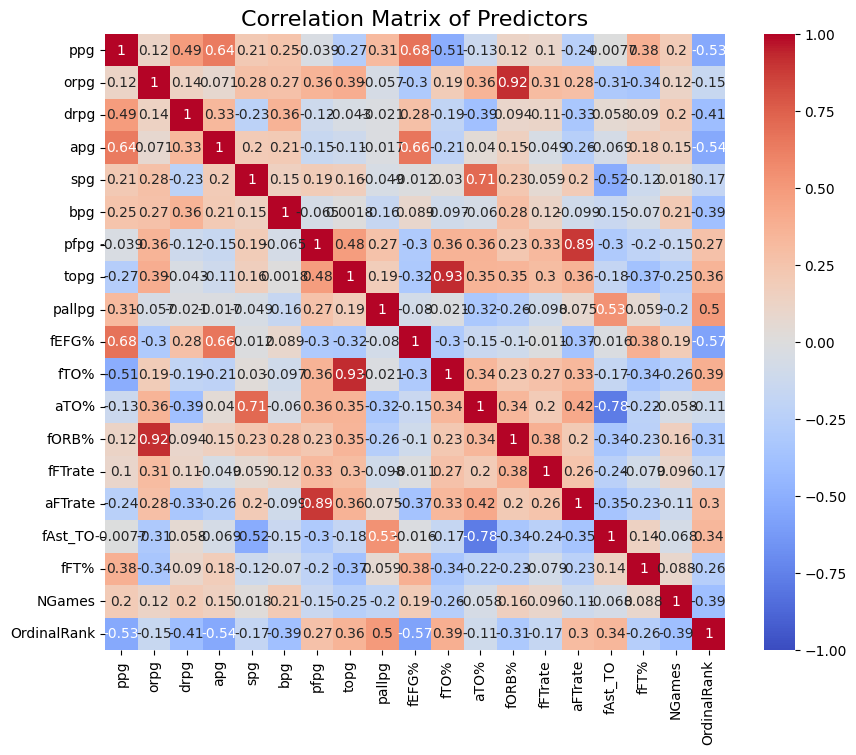

High correlations (|r| > 0.6):
ppg - apg: 0.638
ppg - fEFG%: 0.679
orpg - fORB%: 0.921
apg - fEFG%: 0.659
spg - aTO%: 0.714
pfpg - aFTrate: 0.885
topg - fTO%: 0.929
aTO% - fAst_TO: -0.777


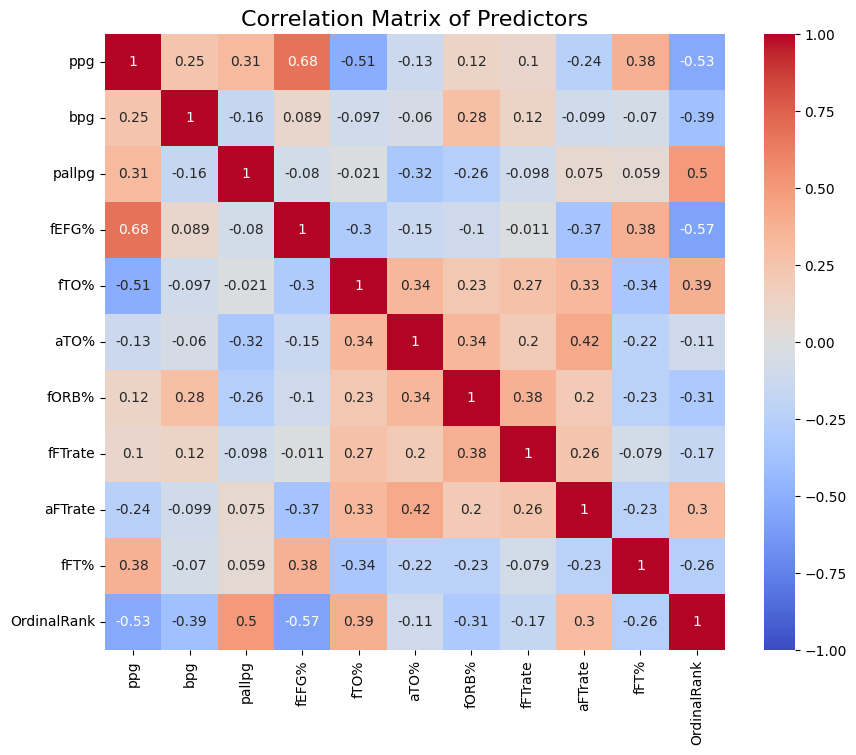

High correlations (|r| > 0.6):
ppg - fEFG%: 0.679


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


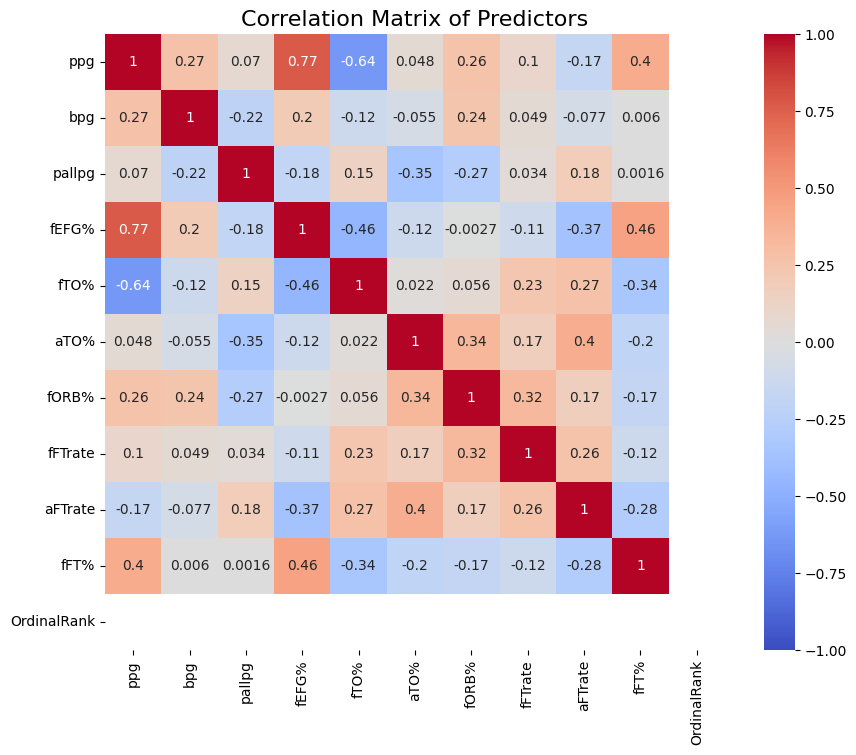

High correlations (|r| > 0.6):
ppg - fEFG%: 0.773
ppg - fTO%: -0.635


<ipython-input-8-e067ca43a5f4>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_stats.drop(columns='OrdinalRank', inplace=True)


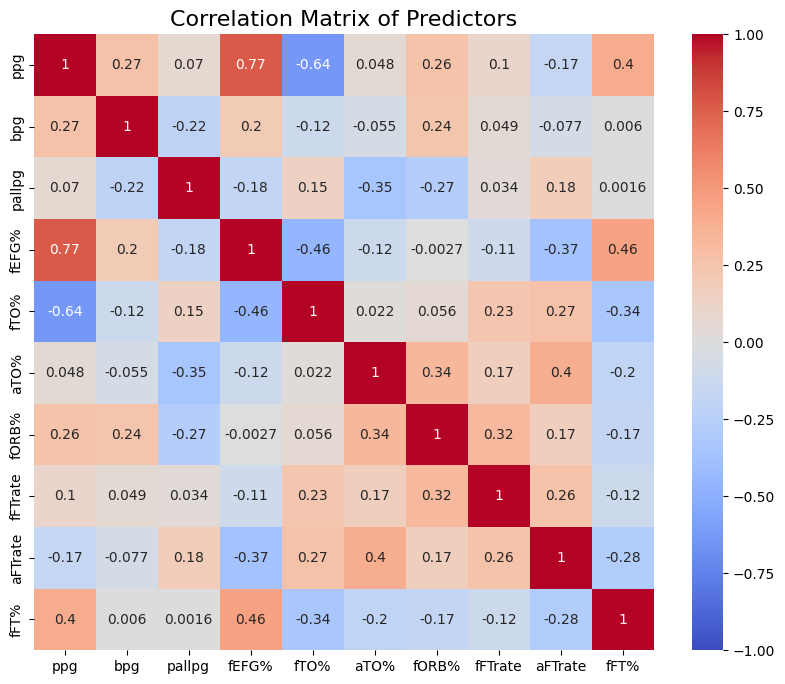

High correlations (|r| > 0.6):
ppg - fEFG%: 0.773
ppg - fTO%: -0.635


In [8]:
def plot_correlation_matrix(df):
    """Plot correlation matrix for predictors."""
    corr = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Predictors', fontsize=16)
    plt.show()
    
    # Print high correlations
    print("High correlations (|r| > 0.6):")
    high_corr = []
    for i in range(len(corr.columns)):
        for j in range(i+1, len(corr.columns)):
            if abs(corr.iloc[i, j]) > 0.6:
                high_corr.append((corr.columns[i], corr.columns[j], corr.iloc[i, j]))
    
    for var1, var2, r in high_corr:
        print(f"{var1} - {var2}: {r:.3f}")
        
X_cols = ['ppg', 'orpg', 'drpg', 'apg', 'spg', 'bpg', 'pfpg', 'topg', 'pallpg', 'fEFG%',
          'fTO%', 'aTO%', 'fORB%', 'fFTrate', 'aFTrate', 'fAst_TO', 'fFT%', 
          'NGames', 'OrdinalRank']

def show_matrix(team_stats):

    global X_cols

    plot_correlation_matrix(team_stats[X_cols])

    # Removing columns that have high correlation with others, and NGames which has low importance
    collinear_cols = ['orpg', 'drpg', 'apg', 'spg', 'pfpg', 'topg', 'fAst_TO', 'NGames']

    X_cols = [item for item in X_cols if item not in collinear_cols]
    
    team_stats = team_stats[['TeamID', 'TeamName', 'ConfAbbrev', 'Season', *X_cols]]

    if (team_stats['TeamID'][0] > 3000):
        team_stats.drop(columns='OrdinalRank', inplace=True)
        X_cols.remove('OrdinalRank')
    
    plot_correlation_matrix(team_stats[X_cols])

    return team_stats

team_stats_men = show_matrix(team_stats_men)
team_stats_women = show_matrix(team_stats_women)

Next, I want to examine each conference in each year to determine the relative strength of the conference relative to the rest of Division I in that season. I scale each column so that the new variables represent the standard deviations above or below the mean. For team-by-team columns, that represents the overall NCAA DI team means. For conferences, it represents the mean across all *conferences* in the country. So half of the columns for each row are specific to that team, and the other half are about the conference that they play in.

In [9]:
def scale_stats(df):
    scaled_df = df.copy()
        
    for season in df['Season'].unique():
        season_mask = df['Season'] == season
            
        for stat in X_cols:
            szn_mean = df.loc[season_mask, stat].mean()
            szn_std = df.loc[season_mask, stat].std()
                    
            scaled_df.loc[season_mask, stat] = (df.loc[season_mask, stat] - szn_mean) / szn_std
        
    return scaled_df

def add_conf_stats(team_stats, t_teams):
    # Average box score results for each conference-season
    conf_stats = team_stats.drop(columns=['TeamName', 'TeamID'])
    conf_stats = conf_stats.groupby(['Season', 'ConfAbbrev']).mean().reset_index().round(2)

    s_conf_stats = scale_stats(conf_stats).add_prefix('conf_')

    s_team_stats = scale_stats(team_stats)
    s_team_stats = pd.merge(s_team_stats,t_teams[['Season', 'TeamID', 'RSeed']], on=['Season', 'TeamID'], how='left')
    s_team_stats['RSeed'] = s_team_stats['RSeed'].fillna(0)

    s_all_stats = pd.merge(s_team_stats, s_conf_stats, left_on=['Season', 'ConfAbbrev'], right_on=['conf_Season', 'conf_ConfAbbrev'])
    s_all_stats.drop(columns=['ConfAbbrev','conf_Season', 'conf_ConfAbbrev'], inplace=True)

    return s_all_stats

s_all_stats_men = add_conf_stats(team_stats_men, t_teams_men)
s_all_stats_women = add_conf_stats(team_stats_women, t_teams_women)

The following cell creates the training data for my predictive models, by linking the team-by-team statistics created above with the outcomes of past March Madness tournament games. Because of the way the original outcomes data is formatted, the winning team's statistics are always listed to the left of the losing team. I wanted to randomize which team is listed first, which required some transformations to split the data and switch the order of exactly half of these rows' columns.

In [10]:
def tourney_games(Tourney, s_all_stats):

    if (s_all_stats['TeamID'][0] < 3000): # Men's
        np.random.seed(16)
        tourney_games = Tourney[['Season', 'WTeamID', 'LTeamID']]
        tourney_games = tourney_games[tourney_games['Season'] >= 2003]
    else: # Women's
        np.random.seed(49)
        tourney_games = Tourney[['Season', 'WTeamID', 'LTeamID']]
        tourney_games = tourney_games[tourney_games['Season'] >= 2010]

    tourney_games.columns = ['Season', 'Team0', 'Team1']
    tourney_games['focus_team'] = np.random.choice([0, 1], size=len(tourney_games))
    tourney_games['win'] = np.where(tourney_games['focus_team'] == 0, 1, 0)
        
    team1s = tourney_games[tourney_games['focus_team'] == 1]
    team1s = pd.merge(team1s, s_all_stats, left_on=['Season', 'Team1'], right_on=['Season', 'TeamID'])
    team1s = pd.merge(team1s, s_all_stats, left_on=['Season', 'Team0'], right_on=['Season', 'TeamID'])
    
    team0s = tourney_games[tourney_games['focus_team'] == 0]
    team0s = pd.merge(team0s, s_all_stats, left_on=['Season', 'Team0'], right_on=['Season', 'TeamID'])
    team0s = pd.merge(team0s, s_all_stats, left_on=['Season', 'Team1'], right_on=['Season', 'TeamID'])
    
    tourney_games = pd.concat([team1s,team0s])
    
    tourney_games['SeedDiff'] = tourney_games['RSeed_x'] - tourney_games['RSeed_y']
    
    tourney_games['Team0'] = tourney_games['TeamID_x']
    tourney_games['Team1'] = tourney_games['TeamID_y']
    
    tourney_games.drop(columns=['focus_team','TeamName_x', 'TeamName_y', 'TeamID_x', 'TeamID_y', 'RSeed_x', 'RSeed_y'], inplace=True)
    
    tourney_games.rename(columns={'Team0': 'TeamID_x', 'Team1': 'TeamID_y'}, inplace=True)

    return tourney_games

tourney_games_men = tourney_games(MTourney, s_all_stats_men)
tourney_games_women = tourney_games(WTourney, s_all_stats_women)

In [11]:
# Predictors will be independent variables in model, wins is the dependent variable

tourney_predictors_men = tourney_games_men.iloc[:,4:]
tourney_wins_men = tourney_games_men['win']

tourney_predictors_women = tourney_games_women.iloc[:,4:]
tourney_wins_women = tourney_games_women['win']

Now I run a random forest model with grid search cross-validation to select the best parameters. Because Brier score loss is the metric of evaluation for the competition, I am using that as the scoring here as well. This represents the mean squared error between predicted probability and game outcome. I'm running various iterations with different train-test splits to find a model that achieves a good test score (below .195) before moving forward to the next step.

In [12]:
brier_scorer = make_scorer(brier_score_loss, needs_proba=True, greater_is_better=False)

def run_random_forest(tourney_predictors, tourney_wins):

    X_train, X_test, y_train, y_test = train_test_split(tourney_predictors, tourney_wins, test_size=0.2)

    # Run a cross-validation test for a random forest model, optimizing Brier score loss
    start_time = time.time()
    
    rf = rnd_frst()
    
    param_grid = {
        'n_estimators': [50,150, 200],
        'max_depth': [5,10,15],
        'min_samples_split': [5, 8],       # Minimum samples required to split a node
        'min_samples_leaf': [2, 4, 6],         # Minimum samples required at a leaf node
        
        # Feature selection parameters
        'max_features': ['auto', 'sqrt'],  # Number of features to consider for best split
    
        'criterion': ['entropy']      # Function to measure quality of split (for classifier)
    }
    
    
    # Perform grid search
    grid_search = GridSearchCV(rf, param_grid, cv=5, error_score='raise',verbose=1,scoring=brier_scorer, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_parameters = grid_search.best_params_
    
    best_model = grid_search.best_estimator_
    
    best_model.fit(X_train, y_train)

    p_hat = best_model.predict_proba(X_test)[:, 1]

    print("Time:", time.time() - start_time)

    return best_parameters, p_hat, y_test
    


In [13]:
best_brier_men = .21
best_forest_params_men = []

best_brier_women = .18
best_forest_params_women = []


for i in range(0, 3):
    forest_params_men, forest_p_hat_men, forest_y_test_men = run_random_forest(tourney_predictors_men, tourney_wins_men)
    forest_params_women, forest_p_hat_women, forest_y_test_women = run_random_forest(tourney_predictors_women, tourney_wins_women)

    comp_men = brier_score_loss(forest_y_test_men, forest_p_hat_men)
    comp_women = brier_score_loss(forest_y_test_women, forest_p_hat_women)

    if comp_men < best_brier_men:
        best_forest_params_men = forest_params_men
        best_brier_men = comp_men
    if comp_women < best_brier_women:
        best_forest_params_women = forest_params_women
        best_brier_women = comp_women
        
    if (best_brier_men < .195) & (best_brier_women < .195):
        break
        

best_forest_men = rnd_frst(**best_forest_params_men)
best_forest_men.fit(tourney_predictors_men, tourney_wins_men)


best_forest_women = rnd_frst(**best_forest_params_women)
best_forest_women.fit(tourney_predictors_women, tourney_wins_women)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Time: 150.15259313583374
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Time: 104.22383880615234
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Time: 144.7501003742218
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Time: 102.21096873283386
Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Time: 144.00835490226746
Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Time: 102.89281558990479


RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2,
                       min_samples_split=8, n_estimators=50)

The following two cells do the same thing, but for an XGBoost model instead. I will be combining the two models' predictions together later.

In [14]:
def run_xgboost(tourney_predictors, tourney_wins):
    
    X_temp, X_test, y_temp, y_test = train_test_split(tourney_predictors, tourney_wins, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2)

    start_time = time.time()
    
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    # Parameter grid for XGBoost
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1, 0.15],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 0.1]
    }
    
    grid_search = GridSearchCV(xgb_model,param_grid,cv=5,scoring=brier_scorer,n_jobs=-1,verbose=1)
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)
    best_xgb = grid_search.best_estimator_
    
    print("Time:", time.time() - start_time)

    p_hat = best_xgb.predict_proba(X_test)[:, 1]

    return grid_search.best_params_, p_hat, y_test

In [15]:
best_brier_men = .21
best_xgb_params_men = {}

best_brier_women = .18
best_xgb_params_women = {}

for i in range(0, 3):
    xgb_params_men, xgb_p_hat_men, xgb_y_test_men = run_xgboost(tourney_predictors_men, tourney_wins_men)
    xgb_params_women, xgb_p_hat_women, xgb_y_test_women = run_xgboost(tourney_predictors_women, tourney_wins_women)

    comp_men = brier_score_loss(xgb_y_test_men, xgb_p_hat_men)
    comp_women = brier_score_loss(xgb_y_test_women, xgb_p_hat_women)

    if comp_men < best_brier_men:
        best_xgb_params_men = xgb_params_men
        best_brier_men = comp_men
    if comp_women < best_brier_women:
        best_xgb_params_women = xgb_params_women
        best_brier_women = comp_men
        
    if (best_brier_men < .195) & (best_brier_women < .195):
        break
        

best_xgb_men = xgb.XGBClassifier(**xgb_params_men)
best_xgb_men.fit(tourney_predictors_men, tourney_wins_men)


best_xgb_women = xgb.XGBClassifier(**xgb_params_women)
best_xgb_women.fit(tourney_predictors_women, tourney_wins_women)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Time: 185.38210582733154
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Time: 127.45885133743286


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Finally, I'm creating the overall predictions by finding every combination of teams in Division I, putting the teams with lower Team IDs first, and merging with their statistics in 2025. I weight the models' predictions: 20% for the random forest model, 70% for the XGBoost model, and 10% for the ratio between the team's championship odds.

In [16]:
def create_predictions(s_all_stats, best_xgb, best_forest, Seeds, Teams, Odds):
    this_season = s_all_stats[s_all_stats['Season'] == 2025]
    this_season_teams = this_season['TeamID'].unique()
    
    this_season_teams = pd.DataFrame(this_season_teams).sort_values(0)

    predictions = pd.DataFrame()
    predictions['ID'] = ['2025_{}_{}'.format(*pair) for pair in combinations(this_season_teams.iloc[:,0], 2)]
    predictions['team_x'] = predictions['ID'].str[5:9].astype(int)
    predictions['team_y'] = predictions['ID'].str[10:14].astype(int)
    predictions['season'] = 2025

    
    predictions = pd.merge(predictions, s_all_stats, left_on=['team_x', 'season'], right_on=['TeamID', 'Season'])
    predictions = pd.merge(predictions, s_all_stats, left_on=['team_y', 'season'], right_on=['TeamID', 'Season'])

    predictions['SeedDiff'] = predictions['RSeed_x'] - predictions['RSeed_y']
    predictions.drop(columns=['TeamID_x', 'TeamName_x', 'Season_x', 
                              'TeamID_y', 'TeamName_y', 'Season_y',
                              'RSeed_x', 'RSeed_y'], inplace=True)
    
    X_2025 = predictions.iloc[:,4:]

    predictions['forest_pred'] = best_forest.predict_proba(X_2025)[:,1]
    predictions['xgb_pred'] = best_xgb.predict_proba(X_2025)[:,1]

    pred_large = pd.merge(Teams[['TeamID', 'TeamName']], predictions, left_on='TeamID', right_on='team_y')
    pred_large = pd.merge(Teams[['TeamID', 'TeamName']], pred_large, left_on='TeamID', right_on='team_x')

    pred_large = pd.merge(pred_large, Odds[['TeamID','champion_odds']], left_on='TeamID_x', right_on='TeamID', how='left')
    pred_large.drop(columns='TeamID', inplace=True)
    pred_large = pd.merge(pred_large, Odds[['TeamID','champion_odds']], left_on='TeamID_y', right_on='TeamID', how='left')
    
    pred_large['market_prob'] = pred_large['champion_odds_x'] / (pred_large['champion_odds_x'] + pred_large['champion_odds_y'])

    pred_large['Pred'] = np.where(pred_large['market_prob'].isna(), 
                                           (0.25 * pred_large['forest_pred']) + (0.75 * pred_large['xgb_pred']), 
                                           (0.15 * pred_large['forest_pred']) + (0.6 * pred_large['xgb_pred']) + (0.25 * pred_large['market_prob']))

    return pred_large

men_pred = create_predictions(s_all_stats_men, best_xgb_men, best_forest_men, MSeeds, MTeams, MOdds)
women_pred = create_predictions(s_all_stats_women, best_xgb_women, best_forest_women, WSeeds, WTeams, WOdds)

In [17]:
all_pred = pd.concat([men_pred, women_pred])
all_pred = all_pred[['ID', 'Pred']]

all_pred.to_csv('/kaggle/working/submission.csv', index=False)